In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import IPython.display as ipd
import os
import sys
import warnings
import IPython.display as ipd
from numpy import savez_compressed
import time

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


####Processed Data
[Here](https://colab.research.google.com/drive/1c-MQBE7sQSJtrOPftzjGAP4biFSvFuJf?usp=sharing) link to the notebook

In [3]:
df = pd.read_csv("/content/drive/MyDrive/ML Project/final _data_with_six_emotions.csv")
df=df[['path','emotion']]
#Defining the X and Y for further processing
X=df['path']
Y_dash=df['emotion']

#Label Encoding the outputs
from sklearn.preprocessing import LabelEncoder
def prepare_targets(y_train):
	le = LabelEncoder()
	le.fit(y_train)
	y_train_enc = le.transform(y_train)
	
	return y_train_enc

Y=prepare_targets(Y_dash)

#**DATA PRE-PROCESSING**

##Visualization

Text(0.5, 1.0, 'Log-frequency power spectogram')

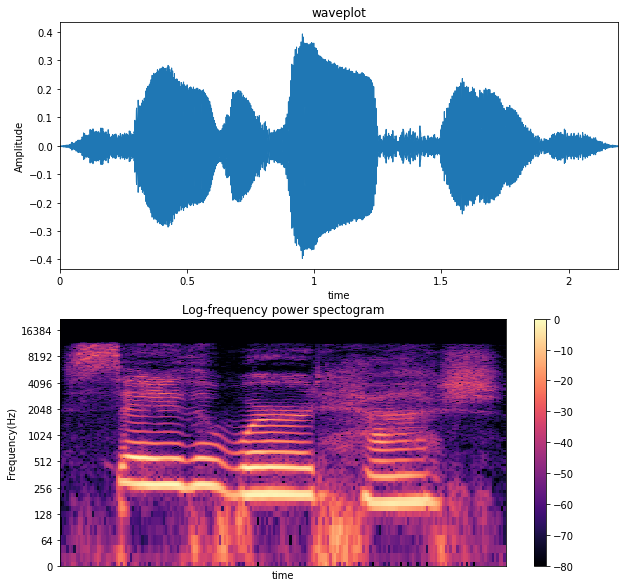

In [4]:
Fs = 44100; # Setting the sampling rate
data, rate = librosa.load(X[0],sr = Fs)
# Finding the Short Time Fourier Transform  (STFT)
data_stft = librosa.stft(data)
#Conversion from amplitude to dB scale to visulaize spectrogram
data_stft_dB = librosa.amplitude_to_db(np.abs(data_stft), ref=np.max)
plt.figure(figsize=(10,10))
plt.subplot(211)
librosa.display.waveplot(data, sr = Fs)
plt.xlabel('time')
plt.ylabel('Amplitude')
plt.title('waveplot')
plt.subplot(212)
# log-frequency power spectogram
librosa.display.specshow(data_stft_dB, y_axis='log', sr=Fs)
plt.colorbar()
plt.xlabel('time')
plt.ylabel('Frequency(Hz)')
plt.title('Log-frequency power spectogram')


##Endpointing

In [5]:
def endpoint(data, threshold):
    data_trim, index = librosa.effects.trim(data, top_db=threshold)
    # Finding the Short Time Fourier Transform  (STFT)
    data_stft = librosa.stft(data_trim)
    #Conversion from amplitude to dB scale to visulaize spectrogram
    data_stft_dB = librosa.amplitude_to_db(np.abs(data_stft), ref=np.max)
    plt.figure(figsize=(10,10))
    plt.subplot(311)
    librosa.display.waveplot(data, sr = Fs)
    plt.xlabel('time')
    plt.ylabel('Amplitude')
    plt.title('waveform of original file')
    plt.subplot(312)
    librosa.display.waveplot(data_trim, sr = Fs)
    plt.xlabel('time')
    plt.ylabel('Amplitude')
    plt.title('waveform after silence removal')
    plt.subplot(313)
    # log-frequency power spectogram
    librosa.display.specshow(data_stft_dB, y_axis='log', sr=Fs)
    plt.colorbar()
    plt.xlabel('time')
    plt.ylabel('Frequency(Hz)')
    plt.title('Log-frequency power spectogram of trimmed file')
    plt.tight_layout()
   
    return data_trim


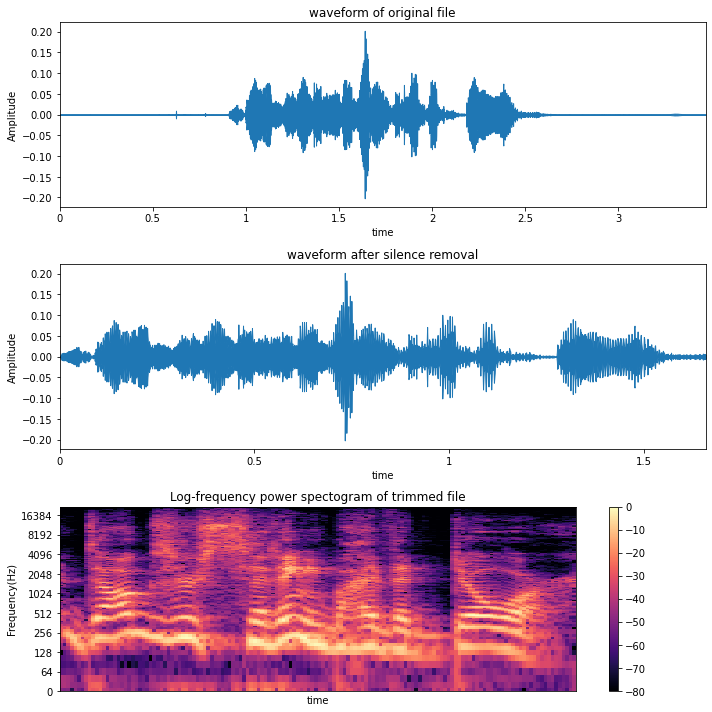

In [6]:
data, rate = librosa.load(X[10500],sr = Fs)
threshold = 25
data_trim = endpoint(data, threshold)

In [7]:
#Listening to orginal file
ipd.Audio(data, rate=rate)

In [8]:
#Listening after endpointing
ipd.Audio(data_trim, rate=rate)

# **Feature Extraction**

## Extraction of MEL- Spectogram

In [ ]:
def getMELspectrogram(path):
     # Frame size = 20ms
    #Window Size = 30ms
    Fs = 44100;
    frame_length = int(Fs*.02);
    n_fft = int(Fs*.03);
    hop_length = n_fft//2;
    threshold = 25;
    data, rate = librosa.load(path,sr = Fs, duration = 3)
    data_trim, index = librosa.effects.trim(data[Fs:], top_db=threshold, frame_length=frame_length) # Removing silence from endpoints
    data_pre = librosa.effects.preemphasis(data_trim,coef=0.95) # Pre-emphasis
    signal = np.zeros((int(rate*2,)))
    signal[:len(data_pre)] = data_pre
    mel_spec = librosa.feature.melspectrogram(y=signal,
                                              sr=rate,
                                              n_fft=n_fft,
                                              win_length = frame_length,
                                              window='hamming',
                                              hop_length = hop_length,
                                              n_mels=128,
                                             )
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

In [ ]:
# Visualizing MEL-Spectogram
mel_feat = getMELspectrogram(X[2664])
print(mel_feat.shape)
librosa.display.specshow(mel_feat, y_axis='mel', x_axis='time')



In [ ]:
# Extracting mel-spectogram features and saving to g-drive
mel_spectogram = []
start = time.time()
i = 0
for path in X:
  feat = getMELspectrogram(path)
  mel_spectogram.append(feat) 
  print(i)
  i+=1
print('time required is:', time.time()-start)
d = np.array(mel_spectogram)
path = '/content/drive/MyDrive/ML Project/mel_feature.npz'
savez_compressed(path,d)
print('time required is:', time.time()-start)


## Combined Features(Mel-Spectogram, MFCCs and Chroma-stft)

Reference: [Here](https://www.kaggle.com/shivamburnwal/speech-emotion-recognition)

In [ ]:
d = []
i = 0
for path in X:
  start = time.time()
  data,rate = librosa.load(path, sr = 44100)

  result = np.array([])

  #chroma_features
  stft = np.abs(librosa.stft(data))
  chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=rate).T, axis=0)
  result = np.hstack((result, chroma_stft)) # stacking horizontally

  # MFCC
  mfcc = np.mean(librosa.feature.mfcc(y=data, sr=rate).T, axis=0)
  result = np.hstack((result, mfcc)) 

  # MelSpectogram
  mel = np.mean(librosa.feature.melspectrogram(y=data, sr=rate).T, axis=0)
  result = np.hstack((result, mel))
  
  i+=1
  d.append(result)
  print(i, '\t', time.time()-start)
  


In [ ]:
#Saving features to g-drive
d = np.array(d)
path = '/content/drive/MyDrive/ML Project/combined_features.npz'
savez_compressed(path,d)
print(d.shape)


## Features with Augmentaion

In [ ]:
d = []
i = 0
for path in X:
  start = time.time()
  data,rate = librosa.load(path, sr = 44100)
  #Adding noise to the signal
  noise_amp = 0.035*np.random.uniform()*np.amax(data)
  data = data + noise_amp*np.random.normal(size=data.shape[0])

  result = np.array([])

  #chroma_features
  stft = np.abs(librosa.stft(data))
  chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=rate).T, axis=0)
  result = np.hstack((result, chroma_stft)) # stacking horizontally

  # MFCC
  mfcc = np.mean(librosa.feature.mfcc(y=data, sr=rate).T, axis=0)
  result = np.hstack((result, mfcc)) # stacking horizontally

  # MelSpectogram
  mel = np.mean(librosa.feature.melspectrogram(y=data, sr=rate).T, axis=0)
  result = np.hstack((result, mel))
  
  i+=1
  d.append(result)
  print(i, '\t', time.time()-start)
  


In [ ]:
#Saving features to g-drive
d = np.array(d)
path = '/content/drive/MyDrive/ML Project/noise_combined_features.npz'
savez_compressed(path,d)
print(d.shape)
